In [1]:
from cytoreactors.inference.BPI import Particles, basic_do_jump, basic_next_jump, basic_jump_params
import numpy as np
import cytoreactors.modeling.EL222_model_2V_3P_A as model
from cytoreactors.modeling.simulation import simulate_analytic, light_profile_to_traj
from  scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
def sample_unif_log(vmin,vmax):
    return vmin*np.exp(np.random.rand()*(np.log(vmax)-np.log(vmin)))

In [3]:
prior_bounds = {'sigma':(500,6000), 'deg_m':(0.8,5.0), 'deg_fp':(0.1,0.7)}
sigma_fp_measurement = 15

In [4]:
def cost_dc(dc, particles):
    return - particles.forecast([(40,dc),(0,1.0-dc)])[:,-1].std()

In [5]:
def search_best_dc(particles):
    res = minimize_scalar(fun=cost_dc,
                        args=(particles),
                        method='Bounded',
                        bounds=(0.,1.))
    dc = res.x
    if dc > 0.99:
        return 1.
    if dc < 0.01:
        return 0.
    return dc

In [8]:
particles = Particles(n_particles=5000, model=model)
for ip in range(particles.n_particles):
    for p in particles.params:
        particles.params[p][ip] = sample_unif_log(prior_bounds[p][0],prior_bounds[p][1])
        
y0 = [0,0]
real_pars = model.default_model_pars
full_lp = []
t = [0]
t_real = []
fp_real = []
fp_meas = []
pars_traj_mean = {p_name:[] for p_name in particles.params}
pars_traj_median = {p_name:[] for p_name in particles.params}
pars_traj_sd = {p_name:[] for p_name in particles.params}
for p_name,p_vals in particles.params.items():
    pars_traj_mean[p_name].append(p_vals.mean())
    pars_traj_median[p_name].append(np.median(p_vals))
    pars_traj_sd[p_name].append(p_vals.std())
    
t0 = 0
for i in range(6):
    #dc = search_best_dc(particles)
    c0,c1 = cost_dc(0,particles),cost_dc(1,particles)
    if c0 < c1:
        dc = 0
    else:
        dc = 1
    print(dc)
    lp = [(40,dc),(0,1.0-dc)]
    t.append(t[-1] + sum(d for _,d in lp))
    tr,y,_ = simulate_analytic(model, real_pars, lp, y0, n_evals=20, t0=t0)
    y0 = y[:,-1]
    t0 = tr[-1]
    fp_noisy = y0[-1] + np.random.normal(scale=sigma_fp_measurement)
    fp_meas.append(fp_noisy)
    t_real.append(tr)
    fp_real.append(y[-1,:])
    particles.advance(lp, basic_next_jump, basic_do_jump, basic_jump_params, particles.param_names)
    particles.treat_new_measurement(fp_noisy, sigma_fp_measurement)
    full_lp += lp
    for p_name,p_vals in particles.params.items():
        pars_traj_mean[p_name].append(p_vals.mean())
        pars_traj_median[p_name].append(np.median(p_vals))
        pars_traj_sd[p_name].append(p_vals.std())
t_real = np.hstack(t_real)
fp_real = np.hstack(fp_real)

1
1
0
1
1
0


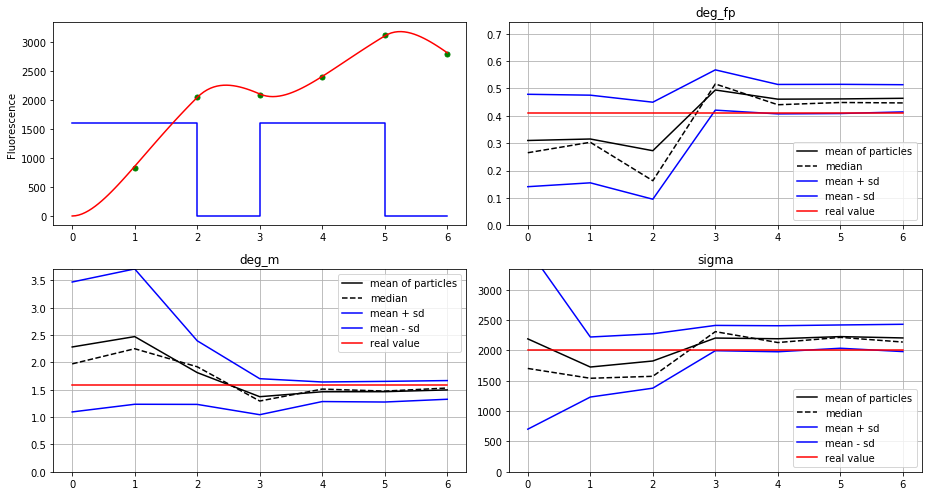

In [9]:
f,axs = plt.subplots(ncols=2, nrows=2, figsize=(13,7))
axs = axs.ravel()
#
ax = axs[0]
tl,l = light_profile_to_traj(full_lp)
ax.plot(tl,l*40,'b')
ax.plot(t[1:],fp_meas,'go',markersize=5)
ax.plot(t_real, fp_real,'r')
ax.set_ylabel('Fluorescence')
iparam = 1
for p in particles.params:
    ax = axs[iparam]
    ax.plot(t, pars_traj_mean[p], 'k')
    ax.plot(t, pars_traj_median[p],'--k')
    ax.plot(t, np.array(pars_traj_mean[p]) - np.array(pars_traj_sd[p]), 'b')
    ax.plot(t, np.array(pars_traj_mean[p]) + np.array(pars_traj_sd[p]), 'b')
    ax.plot([0,t[-1]], [real_pars[p],real_pars[p]], 'r')
    iparam += 1
    ax.set_title(p)        
    ax.set_ylim([0,1.5*max(pars_traj_mean[p])])
    ax.grid()
    ax.legend(['mean of particles','median','mean + sd','mean - sd', 'real value'])
f.tight_layout()

In [14]:
def cost_profile(dcs):
    particles = Particles(n_particles=5000, model=model)
    for ip in range(particles.n_particles):
        for p in particles.params:
            particles.params[p][ip] = sample_unif_log(prior_bounds[p][0],prior_bounds[p][1])
    C = 0
    for dc in dcs:
        lp = [(40,dc),(0,1-dc)]
        particles.advance(lp, None, None, None, [])
        C += particles.states[:,-1].std()
    return -C

In [41]:
def give_all(n):
    current = [[0],[1]]
    for i in range(n-1):
        new = []
        for c in current:
            new.append([0] + c)
            new.append([1] + c)
        current = new
    return current

In [42]:
give_all(3)

[[0, 0, 0],
 [1, 0, 0],
 [0, 1, 0],
 [1, 1, 0],
 [0, 0, 1],
 [1, 0, 1],
 [0, 1, 1],
 [1, 1, 1]]

In [50]:
res = {}
all_dcs = give_all(6)
for i,dcs in enumerate(all_dcs):
    if i%10 == 0:
        print(f'{i}/{len(all_dcs)}')
    res[tuple(dcs)] = cost_profile(dcs)

0/64
5/64
10/64
15/64
20/64
25/64
30/64
35/64
40/64
45/64
50/64
55/64
60/64


In [54]:
max(res)

(1, 1, 1, 1, 1, 1)